### Text Summarization using Machine Leaning techniques

### Exploratory Data Analysis on Text Data

We can read this concept definition on Wikipedia: **"exploratory data analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics, often with visual methods."**. This step is absolutely necessary and has a huge impact on the final result of a model, this analysis will tell us what type of transformation we need to apply on the dataset.

### Imports




In [1]:
!pip install wordcloud
!pip install gensim
!pip install pyLDAvis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import time, os, random, nltk, re, string, unicodedata

from collections import Counter
import gensim
from gensim.summarization.textcleaner import split_sentences
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

np.__version__

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


'1.21.2'

In [3]:
from pyLDAvis import sklearn as sk_lda
import pickle, pyLDAvis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [4]:
pd.__version__

'1.3.2'

### Data
We are going to download the data from [kaggle- inshorts-news-data](https://www.kaggle.com/shashichander009/inshorts-news-data). We will load this data from our google drive.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Global variables
We will define global variables that we are going to use throught this notebook.

In [6]:
punc = string.punctuation
stopword = nltk.corpus.stopwords.words("english")
file_path = "/content/drive/My Drive/NLP Data/text-sum/Inshorts Cleaned Data.xlsx"

In [22]:
stopwords = stopword

### Loading the dataset

We are reading an `excel` file so first we need to install a package called `xlrd` as follows:

In [7]:
!pip install xlrd

When I run the cell `9` i was getting an error `"ImportError: Pandas requires version '3.0.0' or newer of 'openpyxl' (version '2.5.9' currently installed).
"` so I had to install the latest version of `openpyxl` as follows:

In [ ]:
# !pip3 uninstall openpyxl
# !pip3 install openpyxl

In [9]:
summary = pd.read_excel(file_path)
summary.head(5)

,Headline,Short,Source,Time,Publish Date
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...,The New Indian Express,09:25:00,2017-03-26
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...,Outlook,22:18:00,2017-03-25
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a...",Hindustan Times,23:39:00,2017-03-25
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...,Livemint,23:08:00,2017-03-25
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...,YouTube,23:24:00,2017-03-25


### Data definition

**"Inshorts News Data"**. Inshorts is a news service that provides short summaries of news from around the web, scraping the news article from Hindu, Indian times and Guardian. This dataset contains headlines and summary of news items, about 55,000, along with its source.

Example:
An example:

* **Text**: "TV news anchor Arnab Goswami has said he was told he could not do the programme two days before leaving Times Now. 18th November was my last day, I was not allowed to enter my own studio, Goswami added. When you build an institution and are not allowed to enter your own studio, you feel sad, the journalist further said".
* **Summary**: "Was stopped from entering my own studio at Times Now: Arnab" For a better performance, we should consider using a greater dataset like the CNN dataset that contains more than 93,000 news articles.



In [10]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55104 entries, 0 to 55103
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Headline      55104 non-null  object        
 1   Short         55104 non-null  object        
 2   Source        55104 non-null  object        
 3   Time          55104 non-null  object        
 4   Publish Date  55104 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 2.1+ MB


In [11]:

print(summary['Headline'][0],'\n\n',summary['Short'][0],'\n\n',summary['Source '][0])

4 ex-bank officials booked for cheating bank of ₹209 crore 

 The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons. 

 The New Indian Express


We can observe that there are some weired characters, and we need to transform them to ASCII.

### Descriptive statictics

First of all, we extract the basics statistics: count of rows, unique rows, frequencies,... This atributes in the text data will tell us if we need to remove repeated rows or how many rows contains null values in any column.

In [12]:
print('Dataset examples: ', len(summary))
summary.describe()

Dataset examples:  55104


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


,Headline,Short,Source,Time,Publish Date
count,55104,55104,55104,55104,55104
unique,54940,54997,1471,1405,433
top,"Sensex, Nifty end on a flat note",Actor Farhan Akhtar and singers Vishal Dadlani...,YouTube,10:00:00,2016-10-11 00:00:00
freq,9,3,4693,127,236
first,NaN,NaN,NaN,NaN,2016-01-19 00:00:00
last,NaN,NaN,NaN,NaN,2017-03-26 00:00:00


We can observe that there are Two variables describing the text of the news:

* **Short:** this is the longest variable and contains the text of the news
* **Headline:** this is a summary or highlights composed by two or three sentences

In [13]:
#  Remove unnecessary columns
summary.drop(
  ['Source ','Time ', 'Publish Date'], axis=1
)
# Drop duplicates
summary.drop_duplicates(subset=["Short"],inplace=True)

# remove nan rows
summary.dropna(inplace=True)

# reseting the index
summary.reset_index(drop=True,inplace=True)
summary.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  del sys.path[0]


,Headline,Short,Source,Time,Publish Date
count,54997,54997,54997,54997,54997
unique,54939,54997,1471,1405,433
top,"Sensex, Nifty end on a flat note",The CBI on Saturday booked four former officia...,YouTube,10:00:00,2016-10-11 00:00:00
freq,9,1,4685,127,234
first,NaN,NaN,NaN,NaN,2016-01-19 00:00:00
last,NaN,NaN,NaN,NaN,2017-03-26 00:00:00


Our problem is not interested in any others variables except the text or full text of the article and the corresponding summary, so we can remove the Source, Date, etc.

Lets create a new dataframe with the variables we are interested in analyzing.

In [14]:
dataset = summary[["Headline", "Short"]].copy()
dataset.columns = ["summary", "text"]
dataset.head()

,summary,text
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...


### Data cleaning


In [16]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

In [18]:
dataset["text"] = dataset["text"].apply(lambda x:  unicode_to_ascii(x))
dataset["summary"] = dataset["summary"].apply(lambda x:  unicode_to_ascii(x))
dataset.head(5)

,summary,text
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...


In [19]:
print(dataset['summary'][1],'\n',dataset['text'][1],'\n')

Supreme Court to go paperless in 6 months: CJI 
 Chief Justice JS Khehar has said the Supreme Court will go paperless in six to seven months in a bid to save funds and make the judiciary eco-friendly. He further said the apex court will collect all the records electronically from the lower courts and the high courts so that there is no need to file hard copies. 



### Exploring relevant features in the data
The dataset contains only the two columns of interest - summary and text. In this section we will create some additional features that provide relevant information about the composition of our texts. The following list explains different ideas for creating new features:

* Sentence Count - Total number of sentences in the text
* Word Count - Total number of words in the text
* Character Count - Total number of characters in the text excluding spaces
* Sentence density - Number of sentences relative to the number of words
* Word Density - Average length of the words used in the headline
* Punctuation Count - Total number of punctuations used in the headline
* Stopwords Count - Total number of common stopwords in the text



In [24]:
def count_stopwords(text, stopwords):
  word_tokens = word_tokenize(text)
  stopwords_x = [
    w for w in word_tokens if w in stopwords
  ]
  return len(stopwords_x)

It is time to calculate every new feature previously listed.

In [25]:
# Create a new variable containing the number of sentences in the summary
dataset['sum_sent_count'] = dataset['summary'].apply(lambda x : len(split_sentences(x)))
# Create a new variable containing the number of sentences in the text
dataset['text_sent_count'] = dataset['text'].apply(lambda x : len(split_sentences(x)))
# Create a new variable containing the number of word in the summary
dataset['sum_word_count'] = dataset['summary'].apply(lambda x : len(x.split()))
# Create a new variable containing the number of word in the text
dataset['text_word_count'] = dataset['text'].apply(lambda x : len(x.split()))
# Create a new variable containing the number of characters in the summary
dataset['sum_char_count'] = dataset['summary'].apply(lambda x : len(x.replace(" ","")))
# Create a new variable containing the number of characters in the text
dataset['text_char_count'] = dataset['text'].apply(lambda x : len(x.replace(" ","")))
# Create a new variable containing the density of words in the summary
dataset['sum_word_density'] = dataset['sum_word_count'] / (dataset['sum_char_count'] + 1)
# Create a new variable containing the density of words in the text
dataset['text_word_density'] = dataset['text_word_count'] / (dataset['text_char_count'] + 1)
# Create a new variable containing the density of sentences in the summary
dataset['sum_sent_density'] = dataset['sum_sent_count'] / (dataset['sum_word_count'] + 1)
# Create a new variable containing the density of sentences in the text
dataset['text_sent_density'] = dataset['text_sent_count'] / (dataset['text_word_count'] + 1)
# Create a new variable containing the number of punctuations in the summary
dataset['sum_punc_count'] = dataset['summary'].apply(lambda x : len([a for a in x if a in punc]))
# Create a new variable containing the number of punctuations in the text
dataset['text_punc_count'] = dataset['text'].apply(lambda x : len([a for a in x if a in punc]))

# Stopwords
# Create a new variable containing the number of stopwords in the text
dataset['text_stopw_count'] =  dataset['text'].apply(lambda x : count_stopwords(x, stopwords))
# Create a new variable containing the number of stopwords in the summary
dataset['sum_stopw_count'] =  dataset['summary'].apply(lambda x : count_stopwords(x, stopwords))
# Create a new variable containing the density of stopwords in the summary
dataset['sum_stopw_density'] = dataset['sum_stopw_count'] / (dataset['sum_word_count'] + 1)
# Create a new variable containing the density of stopwords in the text
dataset['text_stopw_density'] = dataset['text_stopw_count'] / (dataset['text_word_count'] + 1)

#Print some of the calculated values
print(dataset[['sum_word_count', 'sum_char_count', 'sum_word_density', 'sum_punc_count']].head(5))
print(dataset[['text_word_count', 'text_char_count', 'text_word_density', 'text_punc_count']].head(5))
print(dataset[['text_sent_count', 'sum_sent_count', 'text_sent_density', 'sum_sent_density']].head(5))
print(dataset[['text_stopw_count', 'sum_stopw_count', 'text_stopw_density', 'sum_stopw_density']].head(5))


   sum_word_count  sum_char_count  sum_word_density  sum_punc_count
0              10              49          0.200000               1
1               9              38          0.230769               1
2              11              50          0.215686               2
3               9              45          0.195652               1
4              11              49          0.220000               1
   text_word_count  text_char_count  text_word_density  text_punc_count
0               60              320           0.186916                6
1               58              257           0.224806                3
2               60              324           0.184615                9
3               60              294           0.203390               19
4               60              282           0.212014               19
   text_sent_count  sum_sent_count  text_sent_density  sum_sent_density
0                3               1           0.049180          0.090909
1               

### Analyze the feature distributions on the text variable
Now that we have calculated the new features, we can analyze the descriptive statistics to identify the main insights on the data distribution and outliers.

In [26]:
dataset[['text_sent_count', 'text_word_count', 'text_char_count', 'text_stopw_count', 'text_punc_count']].describe()

,text_sent_count,text_word_count,text_char_count,text_stopw_count,text_punc_count
count,54997.000000,54997.000000,54997.000000,54997.000000,54997.000000
mean,2.864756,58.180392,310.682055,20.904013,14.648163
std,0.631645,2.411083,25.412363,3.503623,8.104087
min,1.000000,40.000000,226.000000,4.000000,2.000000
25%,3.000000,57.000000,293.000000,19.000000,9.000000
50%,3.000000,59.000000,311.000000,21.000000,13.000000
75%,3.000000,60.000000,329.000000,23.000000,19.000000
max,9.000000,67.000000,413.000000,37.000000,73.000000


### Summarizing

* 3 sentences, 60 words and 311 characters per row are the mean values and they are very close to the median values.
* Standard deviations are quite small.
* But we observe that the maximum number of sentences (9) or chars (more than 400) are far away from the mean values, indicating that there are some registers with values out of range or outliers.

Let's dive in these features to get a better understanding by plotting some figures

### Plotting box plots and histograms about text variable


In [27]:
# We declare a new dataframe for plotting porpouses
#data=dataset

# Create a dictionary to title the columns based on their names
labels_dict={'sum_word_count': 'Word Count of Summaries','text_word_count': 'Word Count of Texts',
             'sum_char_count': 'Char Count of Summaries','text_char_count': 'Char Count of Texts',
             'sum_word_density': 'Word Density of Summaries','text_word_density': 'Word Density of Texts',
             'sum_punc_count': 'Punctuation Count of Summaries','text_punc_count': 'Punctuation Count of Texts',
             'text_sent_count': 'Sentence Count of Texts', 'sum_sent_count': 'Sentence Count of Summaries',
             'text_sent_density': 'Sentence Density of Texts', 'sum_sent_density': 'Sentence Density of Summaries',
             'text_stopw_count': 'Stopwords Count of Texts', 'sum_stopw_count': 'Stopwords Count of Summaries',
             'ADJ': 'adjective','ADP': 'adposition', 'ADV': 'adverb','CONJ': 'conjunction',
             'DET': 'determiner','NOUN': 'noun', 'text_unknown_count': 'Unknown words in Texts',
             'sum_unknown_count': 'Unknown words in Summaries',}

In [28]:
def plot_boxplots(data, plot_vars, labels, figsize):
    ''' Plot a box-plot of the variables in the plot_vars list using the labels and a size of figesize
        Input:
        - data: a dataframe, containing the data points to plot
        - plot_vars: a (1,x) array, containig the columns to plot
        - labels: a dctionary, to map the column names to its label
        - figsize: a tuple, indicating the size of the figure
    '''
    
   # We need to identify is this a matrix or a vector
    if plot_vars.ndim == 1:
        nrows=1
        ncols = plot_vars.shape[0]
    else:
        nrows= plot_vars.shape[0]
        ncols = plot_vars.shape[1]

    #Create a figure and its axes for the dimensions defined
    f, axes = plt.subplots(nrows, ncols, sharey=False, figsize=(15,5))
    #For every variable in the plot_vars
    for i in range(nrows):
        for j in range(ncols):
            # If the column name is defined we plot it
            if plot_vars[i,j]!=None:
                if axes.ndim>1:
                    #Set the title
                    axes[i,j].set_title(labels[plot_vars[i,j]])
                    axes[i,j].grid(True)
                    #Set x ticks
                    axes[i,j].tick_params(
                        axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False)
                    # Plot a boxplot for the column in plot_vars
                    axes[i,j].boxplot(data[plot_vars[i,j]])
                else:
                    #Set the title
                    axes[j].set_title(labels[plot_vars[i,j]])
                    axes[j].grid(True)
                    #Set x ticks
                    axes[j].tick_params(
                        axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False)
                    # Plot a boxplot for the column in plot_vars
                    axes[j].boxplot(data[plot_vars[i,j]])
                
            else:
                axes[i,j].set_visible(False)
    # Adjust the plots for a better visualization
    f.tight_layout()
    plt.show() 


def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def plot_histograms(data, plot_vars, xlim, labels, figsize):
    ''' Function to plot the histograms of the variables in plot_vars
        Input:
        - data: a dataframe, containing the data points to plot
        - plot_vars: a (1,x) array, containig the columns to plot
        - xlim: a list, define the max x value for every column to plot
        - labels: a dctionary, to map the column names to its label
        - figsize: a tuple, indicating the size of the figure
    '''
    #Set some parameters
    kwargs = dict(hist_kws={'alpha':.7}, kde_kws={'linewidth':2})

    #cmap = get_cmap(plot_vars.shape[1])
    # Create the figure and axes
    fig, axes = plt.subplots(plot_vars.shape[0], plot_vars.shape[1], figsize=figsize, sharey=False, dpi=100)
    #For every variable in plot_vars
    for i in range(plot_vars.shape[1]):
        # Plot the histogram 
        sns.distplot(data[plot_vars[0,i]] , color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1),), 
                     ax=axes[i], axlabel=labels[plot_vars[0,i]], bins= 50, norm_hist = True)
        #For a better visualization we set the x limit
        axes[i].set_xlim(left=0, right=xlim[i])
        
    fig.tight_layout()
    

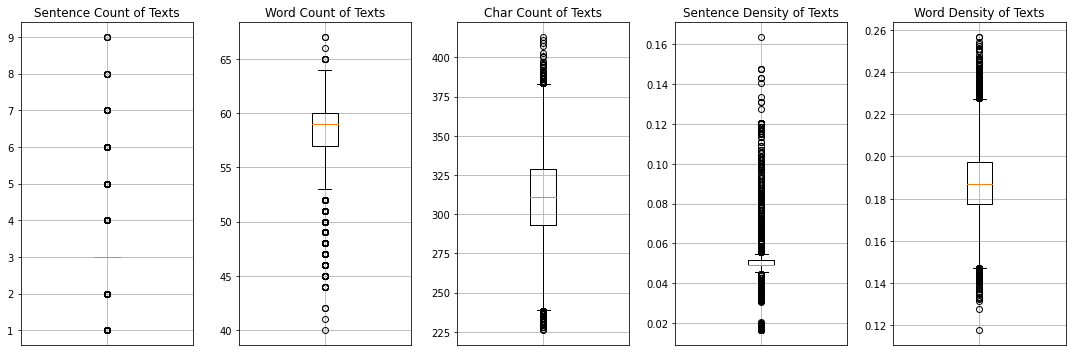

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

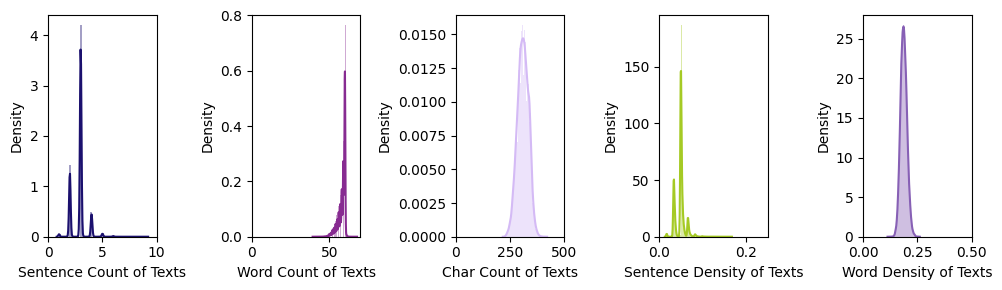

In [29]:
#Set the columns to plot
plot_vars=np.array([['text_sent_count', 'text_word_count', 'text_char_count','text_sent_density','text_word_density']])
# Plot the boxplots for the interesting columns
plot_boxplots(dataset, plot_vars, labels_dict, figsize=(10,3))
# Plot the histograms 
plot_histograms(dataset, plot_vars, [10, 70, 500, 0.25, 0.5], labels_dict, figsize=(10,3))

Above we have plotted the histograms of our features. The count of rows with outliers values is a small number, we can consider removing them but it does not look a great deal. The count of words looks like a left skewed distribution, 75% of rows in the range 55–60 words and the count of char is a normal distribution. We do not identify weird examples or data distributions.

### Analyze the feature distributions on the summary variable

In [30]:
# Extract the descriptive statistics for the summary variable
dataset[['sum_sent_count','sum_word_count', 'sum_char_count', 'sum_sent_density', 'sum_word_density']].describe()

,sum_sent_count,sum_word_count,sum_char_count,sum_sent_density,sum_word_density
count,54997.000000,54997.000000,54997.000000,54997.000000,54997.000000
mean,1.001055,8.255432,44.327872,0.111291,0.183993
std,0.034626,1.540066,6.547859,0.019787,0.034021
min,1.000000,1.000000,2.000000,0.066667,0.070175
25%,1.000000,7.000000,40.000000,0.100000,0.160714
50%,1.000000,8.000000,44.000000,0.111111,0.181818
75%,1.000000,9.000000,49.000000,0.125000,0.205128
max,3.000000,14.000000,76.000000,0.500000,0.363636


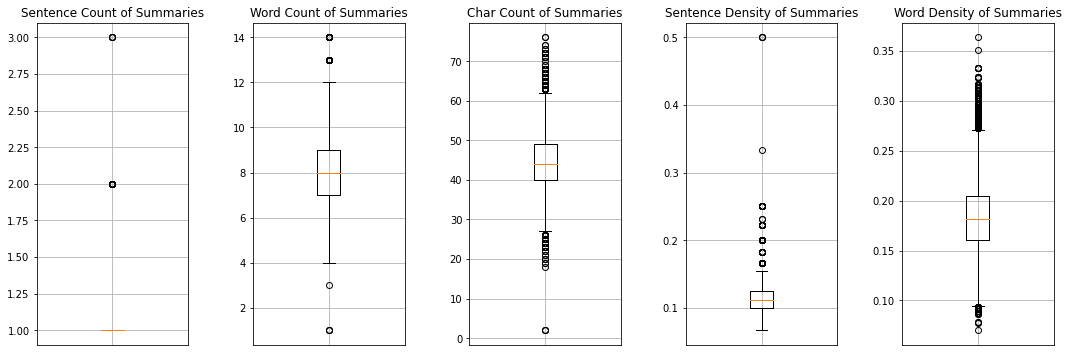

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

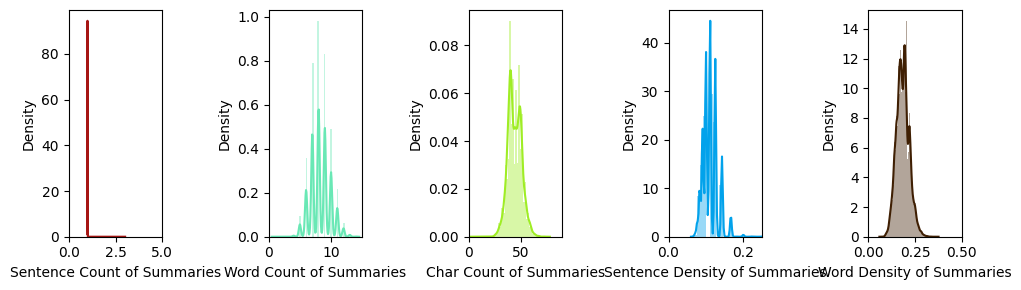

In [31]:
#Set the columns to plot
plot_vars=np.array([['sum_sent_count', 'sum_word_count', 'sum_char_count','sum_sent_density','sum_word_density']])
# Plot the boxplots and histograms for the interesting columns
plot_boxplots(dataset, plot_vars, labels_dict, figsize=(10,3))
plot_histograms(dataset, plot_vars, [5, 15, 90, 0.25, 0.5], labels_dict, figsize=(10,3))

Now, the distributions look like normal and no anomaly is observed:

* The distribution of words and sentence are close to the mean value and the standard deviation is relatively small.
* Most summaries are composed by 1 sentence and the number of words is very close to 7-8.
* The number of chars are around 45
There is only 1 or 2 records with large values. Outliers is not a problem, we can remove them

### Categorizing and Tagging Words

Another group of features we can inspect in text data are the Part-Of-Speech tagging:

The process of classifying words into their parts of speech and labeling them accordingly is known as part-of-speech tagging, POS-tagging, or simply tagging. Parts of speech are also known as word classes or lexical categories... The collection of tags used for a particular task is known as a tagset. Our emphasis in the next section is on exploiting tags, and tagging text automatically.

   ```
   Natural Language Processing with Python, by S. Bird, E. Klein and E. Loper [1]
   ````

Our target in the next section is to identify the POS tags and analyze its distribution on the dataset. Maybe we can observe any interesting behavior but it is not frequent.

Tag Meaning English Examples:
* ADJ, adjective: new, good, high, special, big, local
* ADP,adposition:on, of, at, with, by, into, under
* ADV, adverb: really, already, still, early, now
* CONJ, conjunction: and, or, but, if, while, although
* DET, determiner or article: the, a, some, most, every, no, which
* NOUN, noun: year, home, costs, time, Africa
* NUM,numeral: twenty-four, fourth, 1991, 14:24
* PRT, particle: at, on, out, over per, that, up, with
* PRON, pronoun: he, their, her, its, my, I, us
* VERB, verb: is, say, told, given, playing, would
., punctuation marks:. , ; !
X, othe: ersatz, esprit, dunno, gr8, univeristy

In [32]:
def get_pos_tags(sentences, tagset='universal'):
    ''' Extract the part-of-speech taggings of the sentence
        Input:
        - sentence: string, sentence to tag
        - tagset: string, tagset or the set of tags to search for
    '''
    #Create the Dataframe to store the count of tags
    df = pd.DataFrame(columns=['ADJ','ADP','ADV','CONJ','DET','NOUN','NUM','PRT','PRON','VERB','.','X'])
    for sent in sentences:
        # Extract the part of Speech tags in the sentence
        pos_tags = Counter([j for i,j in nltk.pos_tag(word_tokenize(sent), tagset='universal')])
        #Appends the pos tags to the dataframe, fill NaN values with 0
        df = df.append(pos_tags, ignore_index=True).fillna(0)

    return df.astype(int)

To help us with this task, the NLTK library defines a function ``pos_tag`` which receive a list of words as input and return the part-of-speech tag of every word. Then we can plot a histogram to check the distribution:

In [33]:
# Identify the taggings for the text variable
news_text = dataset['text'].values
df_text = get_pos_tags(news_text)
# Identify the taggings for the summary variable
news_summary = dataset['summary'].values
df_summary = get_pos_tags(news_summary)

df_summary.head()

,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRT,PRON,VERB,.,X
0,1,2,0,0,0,4,1,0,0,2,0,0
1,0,1,0,0,0,5,1,1,0,1,1,0
2,1,3,0,0,0,3,2,0,0,2,2,0
3,0,2,1,0,0,3,0,0,0,3,1,0
4,1,2,1,0,0,4,0,0,1,2,1,0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

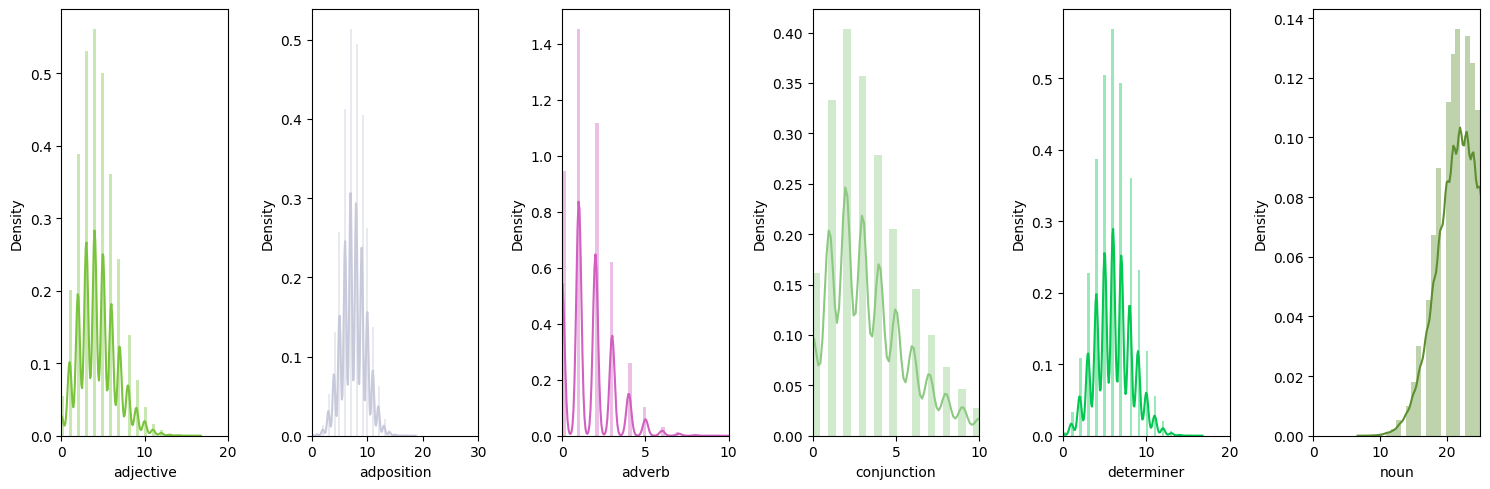

In [34]:
# Select the columns to plot: those related to pos taggings
plot_vars=np.array([['ADJ','ADP','ADV','CONJ','DET','NOUN']])
# Plot a histograms of the variables 
plot_histograms(df_text, plot_vars, [20, 30, 10, 10, 20, 25], labels_dict, figsize=(15,5))

### Check for unknown words

It may be very common that unknown words are included in our texts and summaries, consequently, we should analyze them and you probably have to define how to deal with them. Most of the unknown words are names, surnames, locations or even mispelled words, which we have to decide to correct or not them.

In order to search for these words, we need a vocabulary to compare to. In this case, we use the Glove embeddings, checking if our words are included in those embeddings.

In [35]:
class GloveVectorizer:
  '''Class to store the vocabulary of our texts, including mappings between words and its integer representation. 
     It also contain the embeddings of the vocab to transform every token or integer value
  '''
  def __init__(self, embedding_file):
    ''' Build the embeddings, load them from a file and store it in a list of embedded vectors '''
    # load in pre-trained word vectors
    print('Loading word vectors...')
    word2vec = {}
    embedding = []
    idx2word = []
    with open(embedding_file, encoding='utf8') as f:
      # is just a space-separated text file in the format:
      # word vec[0] vec[1] vec[2] ...
      for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
        embedding.append(vec)
        idx2word.append(word)
    print('Found %s word vectors.' % len(word2vec))

    # save for later
    self.word2vec = word2vec
    self.embedding = np.array(embedding)
    self.word2idx = {v:k for k,v in enumerate(idx2word)}
    self.V, self.D = self.embedding.shape

  def fit(self, data):
    pass

  def transform(self, data):
    ''' Include the tokens contained in the data in the vocabulary'''
    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    # For every sentence in the data
    for sentence in data:
      tokens = sentence.lower().split() # Extract the words
      vecs = []
      unknowns=0
      # For every word in the setence
      for word in tokens:
        # Include the embedded word in the output list 
        if word in self.word2vec:
          vec = self.word2vec[word]
          vecs.append(vec)
        else:
          unknowns += 1  
      # Calculate the embedding of a data as the mean of the embeddings of every word 
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    #print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X

  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)
    

In [36]:
def replace_punctuation(text, punctuation):
    ''' Replace punctuation with whitespace'''
    table=str.maketrans(punctuation, ' '*len(punctuation))
    return text.translate(table)

def unknown_words(text, vocab):
    ''' Return the unknow words found in the text, those not found in the embeddings '''
    tokens = word_tokenize(text)
    unknown = [t for t in tokens if t not in vocab.word2vec]
    
    return unknown

In [38]:
# Set the filename containing the embeddings
glove_file = '/content/drive/My Drive/NLP Data/glove.6B/glove.6B.100d.txt'
glove_filename = os.path.join(glove_file)
#Load the Glove embeddings
vectorizer = GloveVectorizer(glove_filename)

Loading word vectors...
Found 400000 word vectors.


In [39]:
# Clean the text to tokenize and extract the unknown words
dataset['text_unknown_words'] = dataset['text'].apply(lambda x : replace_punctuation(x.lower(), string.punctuation))
dataset['text_unknown_words'] = dataset['text_unknown_words'].apply(lambda x : unknown_words(x, vectorizer))
# Count the ocurrencies of unknown words in the text
dataset['text_unknown_count'] = dataset['text_unknown_words'].apply(lambda x : len(x))

In [40]:
# Clean the summary to tokenize and extract the unknown words
dataset['sum_unknown_words'] = dataset['summary'].apply(lambda x : replace_punctuation(x.lower(), string.punctuation))
dataset['sum_unknown_words'] = dataset['sum_unknown_words'].apply(lambda x : unknown_words(x, vectorizer))
# Count the ocurrencies of unknown words in the summary
dataset['sum_unknown_count'] = dataset['sum_unknown_words'].apply(lambda x : len(x))


We can show the distribution of the unknown words in our texts to get a fast insight of their relevance:

In [41]:
# Extract the descriptive statistics for the summary variable
dataset[['text_unknown_count', 'sum_unknown_count']].describe()

,text_unknown_count,sum_unknown_count
count,54997.000000,54997.000000
mean,0.807008,0.185392
std,1.257573,0.451393
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,20.000000,5.000000


Examples

In [42]:
print('Unknown words: ', dataset['text_unknown_words'].values[5])
print('Unknown words: ', dataset['text_unknown_words'].values[50])
print('Unknown words: ', dataset['text_unknown_words'].values[100])

Unknown words:  ['gadot']
Unknown words:  []
Unknown words:  []



Lets plot some histograms to observe how the distribution of unknown words looks like

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


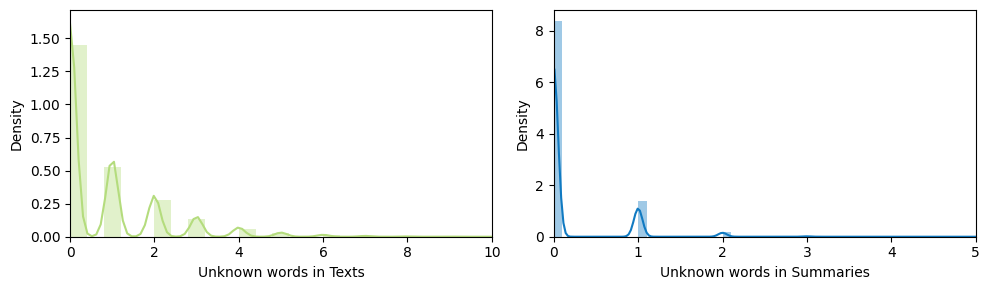

In [43]:
# Set the columns to plot, the unknown words in the text and summary
plot_vars=np.array([['text_unknown_count', 'sum_unknown_count']])
# Plot the histograms
plot_histograms(dataset, plot_vars, [10, 5], labels_dict, figsize=(10,3))

* In our source texts the mean is 0.8 and 75% of the sentences are below 1. We can conclude that they are not an issue, we just can ignore them.
* In the case of the summary variable, unknown words are not present.
* There are 1 or 2 examples with unknown words, we can remove them or just ignore them.

### Use of stopwords and punctuations
Now that we have a more accurate vision of the composition of our texts, we need to analyze the use of stopwords and punctuation, this analysis will indicate us if these "special type" of characters will be removed or transform when we train our models.

As we did previously, the NLTK library provide us with a list of stopwords for english texts, so we can look for them in our dataset. Now, lets explore the histograms of the count of stopwords and punctuations, to get a better intuition about the texts we are going to work with.

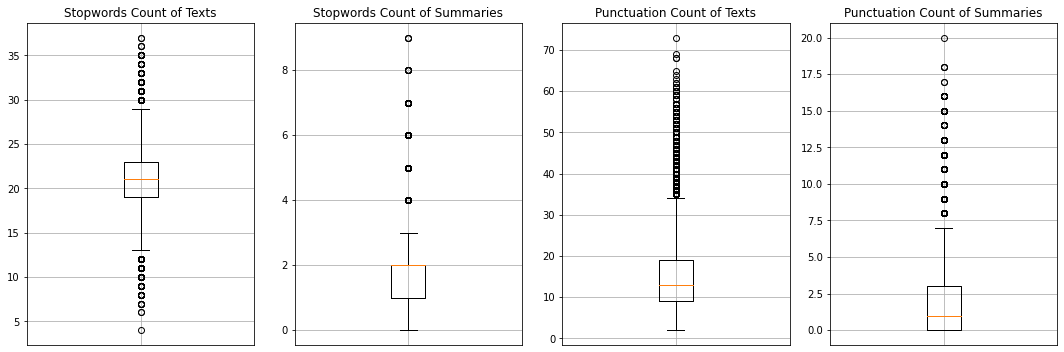

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

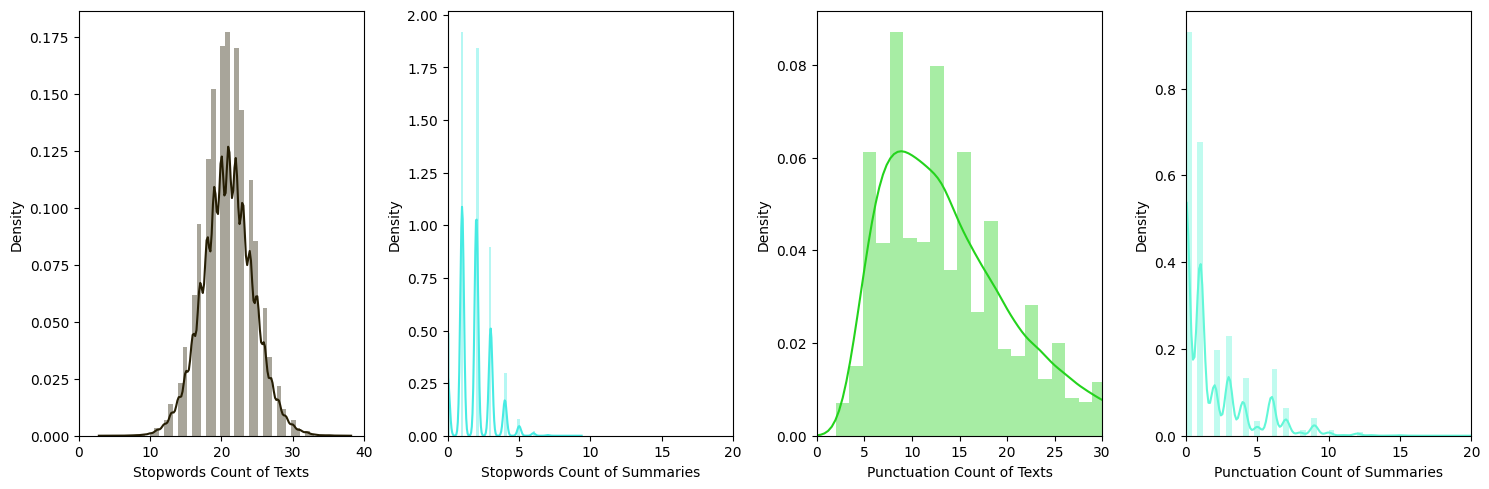

In [44]:

# Set the columns to plot, those relatives to stopwords and punctuation
plot_vars=np.array([['text_stopw_count', 'sum_stopw_count', 'text_punc_count','sum_punc_count']])
# Plot the bosplot and histograms
plot_boxplots(dataset, plot_vars, labels_dict, figsize=(15,5))
plot_histograms(dataset, plot_vars, [40, 20, 30, 20], labels_dict, figsize=(15,5))


### Data Cleaning
Next, let’s perform a simple preprocessing on the content of the text column to make them more amenable for analysis, and reliable results. To do that, we’ll remove any punctuation, digit and then lowercase the text

In [45]:
def clean_text(text, stopwords):
    ''' Apply some basic techniques for cleaning a text for an analysis of words
    
    Input:
       - text: text to be cleaned
    Output:
       - result: cleaned text
    '''
    # Lowercase the text
    text = text.lower()
    # Remove any  non-alphabet characters including digits
    pattern =  r'[^a-zA-Z\s]'    
    text = re.sub(pattern, '', text)
    # Remove punctuation
    #table=str.maketrans('','',string.punctuation)
    #text = text.translate(table)
    # Remove the stopwords    
    tokens = nltk.word_tokenize(text)    
    tokens = [token.strip() for token in tokens]    
    text = ' '.join([token for token in tokens if token not in stopwords])
    return text


### Most frequent terms and Wordclouds using word clouds

In [46]:
#Clean the source text and te summary in our dataset
cleaned_summary = dataset['summary'].apply(lambda x : clean_text(x,stopwords))
cleaned_text = dataset['text'].apply(lambda x : clean_text(x, stopwords))

Build the wordcloud for source texts

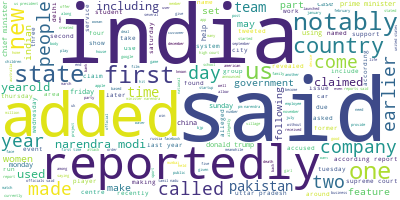

In [47]:
# Join the different processed texts together.
long_string = ','.join(list(cleaned_text.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

Now it is time to build the Cloud of Words for the summaries

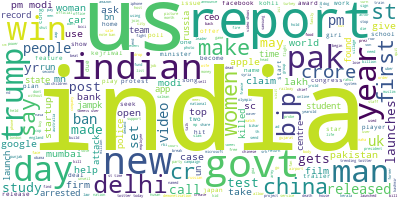

In [48]:
# Join the different processed titles together.
long_string = ','.join(list(cleaned_summary.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()



### Topic Modeling
In our next step, we will learn how to identity which topics are discussed in our texts, this process is called topic modelling. **"In machine learning and natural language processing, a topic model is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents"** by Wikipedia. Using a unsupervised technique, this method tries to find semantic structures in a text in order to classified group of related words in a topic representation.

In particular, we will cover Latent Dirichlet Allocation **(LDA)**: a widely used topic modelling technique. And we will apply LDA to convert our set of source texts to a set of topics.

_There are several existing algorithms you can use to perform the topic modeling. The most common of it are, Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA), and Latent Dirichlet Allocation (LDA)_

```
[5], "Topic Modeling in Python: Latent Dirichlet Allocation (LDA)" by Shashank Kapadia.
```

But first, we need to transform our text data to a format that will serve as an input to the LDA model. We convert the text to a vector representation where each word is replaced by an integer. In this case we will apply the ``CountVectorized`` method.

In [49]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    ''' Draw a barplot showing the tenth most common words in the data
        Input:
        - count_data: tuple, containing pairs of document-term and its ocurrencies in the text
        - count_vectorizer: CountVectorizer object
    '''
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

In [50]:
# Initialise the count vectorizer
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
# Apply the count vectorized method to our cleaned data
tf = tf_vectorizer.fit_transform(cleaned_text)
# Build the Document Term Matrix
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
print(doc_term_matrix)

       aadhaar  aadmi  aam  aamir  aap  ...  zimbabwe  zone  zones  zoo  zuckerberg
0            0      0    0      0    0  ...         0     0      0    0           0
1            0      0    0      0    0  ...         0     0      0    0           0
2            0      0    0      0    0  ...         0     0      0    0           0
3            0      0    0      0    0  ...         0     0      0    0           0
4            0      0    0      0    0  ...         0     0      0    0           0
...        ...    ...  ...    ...  ...  ...       ...   ...    ...  ...         ...
54992        0      0    0      0    0  ...         0     0      0    0           0
54993        0      0    0      0    0  ...         0     0      0    0           0
54994        0      0    0      0    0  ...         0     0      0    0           0
54995        0      0    0      0    0  ...         0     0      0    0           0
54996        0      0    0      0    0  ...         0     0      0    0     

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


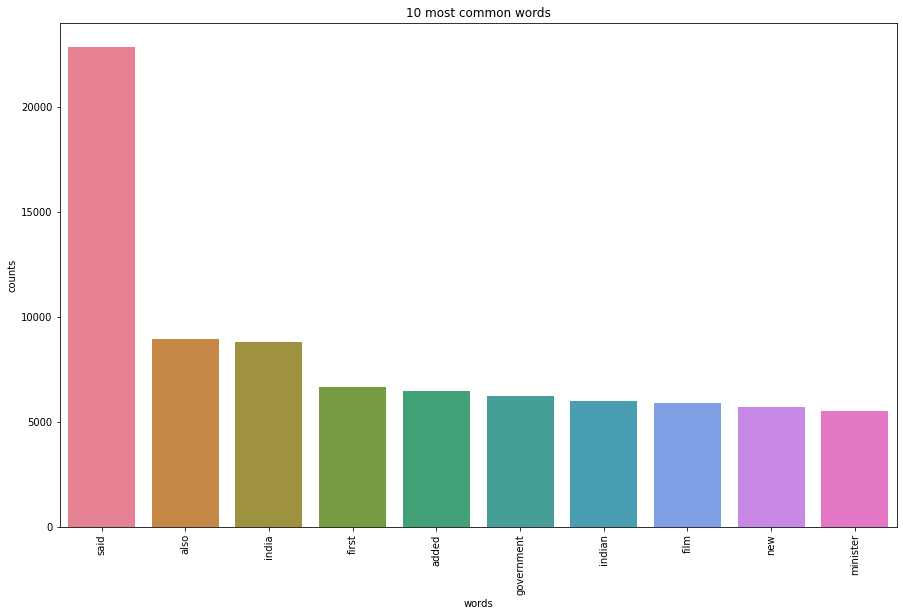

In [51]:
plot_10_most_common_words(tf, tf_vectorizer)

### Extract the topic modelling
The next cells will allow us to discover topics in our texts, group of words with co-ocurrences in the documents. The Scikit-learn library provides a function to calculate LDA and return a list with the topic and the tokens that include. In our example, we define 10 topics to discover and show the main 8 elements or words in each one:

In [52]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    ''' Print the topics detected and the n_top_words that contains
    Input:
       - model: LDA model for the text
       - count_cectorizer: the count vectorizer object
       - n_top_words: the number of words to consider in a topic
    '''
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [ ]:
# Apply the LDA method to discover the topics
lda_model = LDA(n_components=10, learning_method='online', max_iter=500, random_state=0).fit(tf)
# Show the topics and the 8 more relevant words in each topic
no_top_words = 8
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_model, tf_vectorizer, no_top_words)